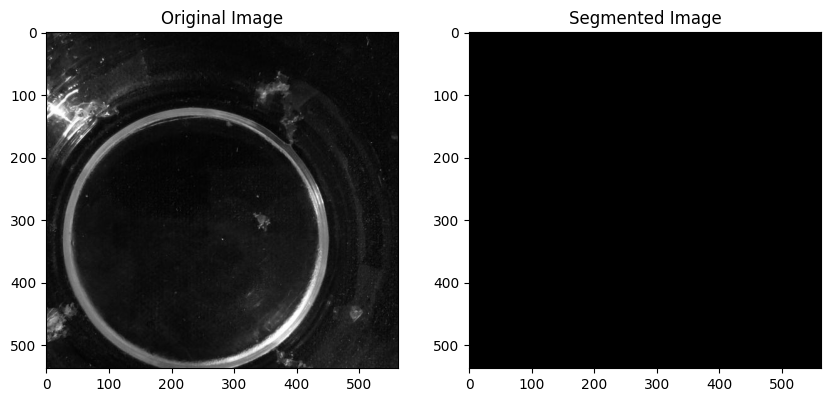

In [2]:
import cv2
import numpy as np
import networkx as nx
from skimage.color import rgb2gray
from skimage import img_as_float
from networkx.algorithms.flow import minimum_cut
import matplotlib.pyplot as plt


image =  cv2.imread('Rename.jpg', cv2.IMREAD_GRAYSCALE)
gray_image = img_as_float(image) # Convert to grayscale for simplicity

# Get image dimensions
h, w = gray_image.shape

# Initialize a graph
G = nx.Graph()

# Step 2: Define helper function to map pixel coordinates to graph nodes
def pixel_id(x, y):
    return x * w + y

# Add nodes and edges for pixel neighborhood based on intensity difference
for i in range(h):
    for j in range(w):
        if i < h - 1:
            diff_v = abs(gray_image[i, j] - gray_image[i + 1, j])
            G.add_edge(pixel_id(i, j), pixel_id(i + 1, j), weight=diff_v)
        if j < w - 1:
            diff_h = abs(gray_image[i, j] - gray_image[i, j + 1])
            G.add_edge(pixel_id(i, j), pixel_id(i, j + 1), weight=diff_h)

# Step 3: Calculate sigma (standard deviation of pixel intensities)
sigma = np.std(gray_image)

# Step 4: Normalize edge weights using Gaussian function (similarity)
for u, v, data in G.edges(data=True):
    data['weight'] = np.exp(-data['weight'] ** 2 / (2 * sigma ** 2))

# Step 5: Perform minimum cut on the graph
source = pixel_id(0, 0)  # Set top-left corner as the source
sink = pixel_id(h - 1, w - 1)  # Set bottom-right corner as the sink

# Apply minimum cut
cut_value, partition = minimum_cut(G, source, sink, capacity='weight')

# Step 6: Extract the segmented region (reachable nodes represent the foreground)
reachable_nodes, non_reachable_nodes = partition

# Initialize a segmented image (black background)
segmented_image = np.zeros_like(gray_image)

# Fill in the segmented area (foreground)
for node in reachable_nodes:
    x = node // w
    y = node % w
    segmented_image[x, y] = gray_image[x, y]

# Step 7: Display the original and segmented images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Image')

plt.show()
